# Analyzing ECoG Signals from Dataset 4 of the BCI Competition



The goal of this element of the competition is to predict the flexion of individual fingers from signals recorded from the surface of the brain (electrocorticography (**ECoG**)). This data set contains
brain signals from three subjects, as well as the time courses of the flexion of each of five fingers.
The task in this competition is to use the provided flexion information in order to **predict** finger flexion for a provided test set. The performance of the classifier will be evaluated by calculating the average correlation coefficient r between actual and predicted finger flexion.

<br>

In [ ]:
import numpy as np
import tensorflow as tf
import keras

In [ ]:
import matplotlib as plt
%matplotlib inline

In [ ]:
# For the baseline correction #
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.fftpack import fftfreq, irfft, rfft

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import scipy.io

sub1 = scipy.io.loadmat('/content/drive/MyDrive/Colab Notebooks/sub1_comp.mat')
# sub2 = scipy.io.loadmat('sub2_comp.mat')
# sub3 = scipy.io.loadmat('sub3_comp.mat')

print(sub1.keys())

print(sub1['train_data'].shape, sub1['test_data'].shape, sub1['train_dg'].shape)
# print(sub2['train_data'].shape, sub2['test_data'].shape, sub2['train_dg'].shape)
# print(sub3['train_data'].shape, sub3['test_data'].shape, sub3['train_dg'].shape)

dict_keys(['__header__', '__version__', '__globals__', 'train_data', 'test_data', 'train_dg'])
(400000, 62) (200000, 62) (400000, 5)


In [ ]:
sub1_eval = scipy.io.loadmat('/content/drive/MyDrive/Colab Notebooks/sub1_testlabels.mat')
print(sub1_eval.keys())

dict_keys(['__header__', '__version__', '__globals__', 'test_dg'])


<br>

So from above we can see the amount of data to be processed
Each of the training datasets were measured for 400 seconds (6mins 40s) sampled at 1000Hz, giving 400000 samples in total from the channels
Subject 1 has 62 channels of ECoG recordings, Subject 2 has 48 and Subject 3 has 64.

An important thing to notice is that the finger trajectory data has 400000 values even though it was sampled at a rate of 25 Hz, meaning only 10000 values. This means that the original finger trajectory data was upsampled to 1000 Hz.

<br>

In [ ]:
print(sub1['train_data']) # Numerical look of the data of the ECoG signals

[[  193  -491 -4293 ...  1827  3096  2395]
 [   96  -451 -4419 ...  1794  3120  2497]
 [  329  -272 -4380 ...  1668  3236  2569]
 ...
 [ 1047  -588  1257 ...  3559  2951  1856]
 [  841  -834   962 ...  3342  2703  2135]
 [  672 -1009   563 ...  3131  2515  2187]]


In [ ]:
print(sub1['train_dg']) #Numerical look of the finger movements

[[-0.40011286  0.1732757   0.99956459 -0.06184273  0.41964019]
 [-0.40011286  0.1732757   0.99956459 -0.06184273  0.41964019]
 [-0.40011286  0.1732757   0.99956459 -0.06184273  0.41964019]
 ...
 [-0.61251224 -0.34792878 -0.21741923 -0.17560933 -0.07191979]
 [-0.61251224 -0.34792878 -0.21741923 -0.17560933 -0.07191979]
 [-0.61251224 -0.34792878 -0.21741923 -0.17560933 -0.07191979]]


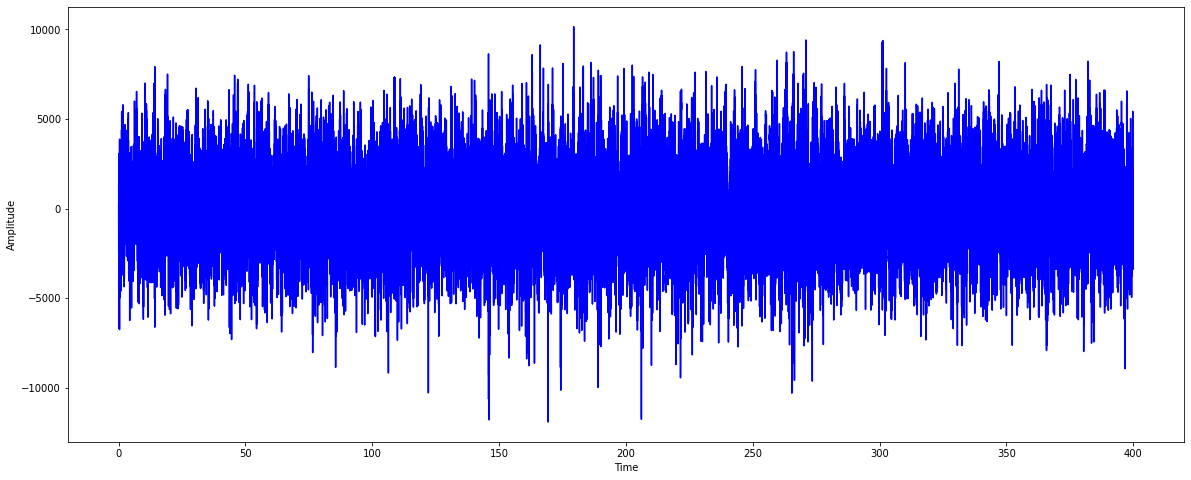

In [ ]:
#print(sub1['train_data'][:, 0]) #channel 1 temporal data of ECoG signals from Subject 1

figure = plt.pyplot.figure(figsize=(20, 8))
plt.pyplot.xlabel('Time')
plt.pyplot.ylabel('Amplitude')
time = np.linspace(0, 400, 400000)
plt.pyplot.plot(time, sub1['train_data'][:, 0], 'b')

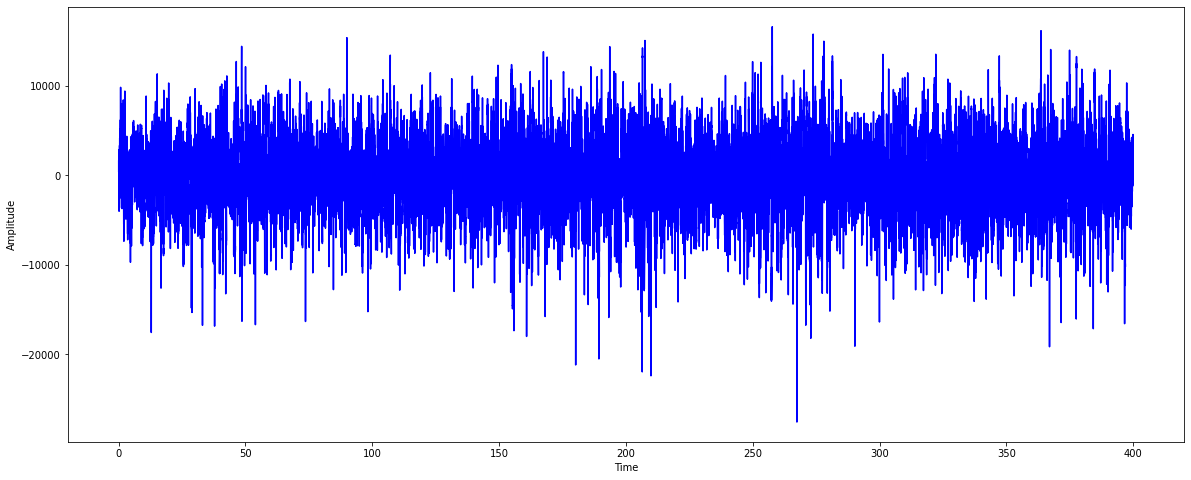

In [ ]:
figure = plt.pyplot.figure(figsize=(20, 8))
plt.pyplot.xlabel('Time')
plt.pyplot.ylabel('Amplitude')
time = np.linspace(0, 400, 400000)
plt.pyplot.plot(time, sub1['train_data'][:, 50], 'b')

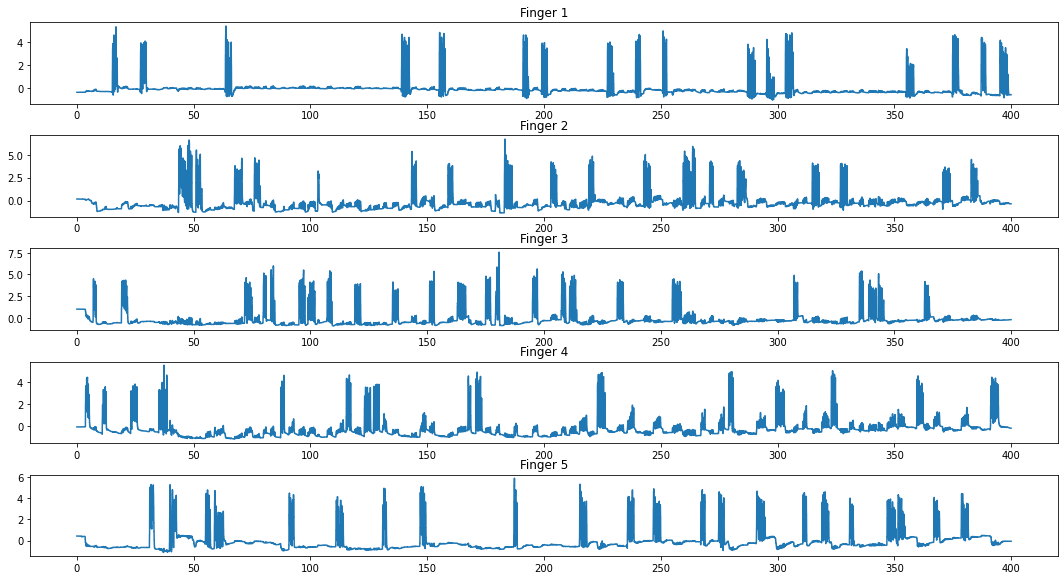

In [ ]:
fig_fingers, axes = plt.pyplot.subplots(figsize = (15,8), nrows = 5, ncols = 1)
plt.pyplot.tight_layout()
axes[0].set_title('Finger 1')
axes[0].plot(time, sub1['train_dg'][:, 0])
axes[1].set_title('Finger 2')
axes[1].plot(time, sub1['train_dg'][:, 1])
axes[2].set_title('Finger 3')
axes[2].plot(time, sub1['train_dg'][:, 2])
axes[3].set_title('Finger 4')
axes[3].plot(time, sub1['train_dg'][:, 3])
axes[4].set_title('Finger 5')
axes[4].plot(time, sub1['train_dg'][:, 4])

The Cell below shows tries to visualize one of the channel's output correspoding to the movement of one of the fingers. This output is all from the first subject only. A 5 second window is considered and the first 55 seconds of the experiment are output. If you do not see a correlation or a pattern between the fingers flexionn and the ECoG signal from the first channel, it might be because these are not discernible to our human eyes. There are also 61 more channels to look at, corresponding to different centres in the brain.

In [ ]:
# i = 0
# for i in range(0, 55, 5):
#     fig, axes = plt.pyplot.subplots(figsize = (10,4), nrows=1, ncols = 2)
    
#     time_axis = np.linspace(i, i+5, 5000)
#     ychannel = sub1['train_data'][i*1000:i*1000+5000, 0]
#     yfinger = sub1['train_dg'][i*1000:i*1000+5000, 0]
    
#     axes[1].set_ylim([-0.5, 5])
    
#     axes[0].plot(time_axis, ychannel, 'r')
#     axes[1].plot(time_axis, yfinger, 'b')
#     plt.pyplot.pause(1)

<br>

# Preprocessing
<hr>

Some methods I compiled that may be used to preprocess the signals:
1. Remove channels 51 of subject 1, channel 21 and 38 of subject 2 and channel 49 of subject 3
2. Baseline Drift correction of finger/make negative values 0
3. Apply an averaging filter on the finger data or threshold the in-between values in the finger data. Maybe we can use a 1-D Gaussian filter of maybe size 1001? and convolve with the signal with stride=1.
4. Create the 3 band specific ECoG signals (sub-band, gamma bad and fast gamma band), _Sanchez et al._ using equiripple finite pulse response
5. Amplitude Modulation

<br>

In [ ]:
## Removing the noisy ECoG channels ##
sub1['train_data'] = np.delete(sub1['train_data'], 50, 1)
print(sub1['train_data'].shape)

# sub2['train_data'] = np.delete(sub2['train_data'], [20, 37], 1)
# print(sub2['train_data'].shape)

# sub3['train_data'] = np.delete(sub3['train_data'], 48, 1)
# print(sub3['train_data'].shape)

(400000, 61)


In [ ]:
sub1['test_data'] = np.delete(sub1['test_data'], 50, 1)

In [ ]:
## Applying baseline correction ##
# Alogrithm from paper on Baseline Correction using Asymmetric Least Squares Smoothing, P. Eilers and H.Boelens #

# 1st - baseline drift correction
# 2nd - normalize
# 3rd - set negative values to 0


def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

# The second processing technique
def process2(finger):
    new_finger = baseline_als(finger, 100000, 0.05) # lamda set to 1e5 and p set to 0.05(>0.001 and <0.1)
    
    # Normalizing the array
    maxElement = np.amax(new_finger)
    new_finger /= maxElement
    
    # Threseholding the signal to have no negative value
    new_finger[new_finger < 0] = 0
    
    return new_finger
    

# i = 0
#iterating over all fingers for a particular subject

# fig_fingers, axes = plt.pyplot.subplots(figsize = (8,4), nrows = 5, ncols = 1)
# plt.pyplot.tight_layout()

# for i in range(0, 5):
#     new_finger = process2(sub1['train_dg'][:, i]) # Change the assignment to sub1['train_dg'] later
#     x = np.linspace(0, 10, 10000)

#     axes[i].set_title("Finger {n}".format(n = i))
#     axes[i].plot(sub1['train_dg'][:, i])
#     axes[i].plot(new_finger)
    

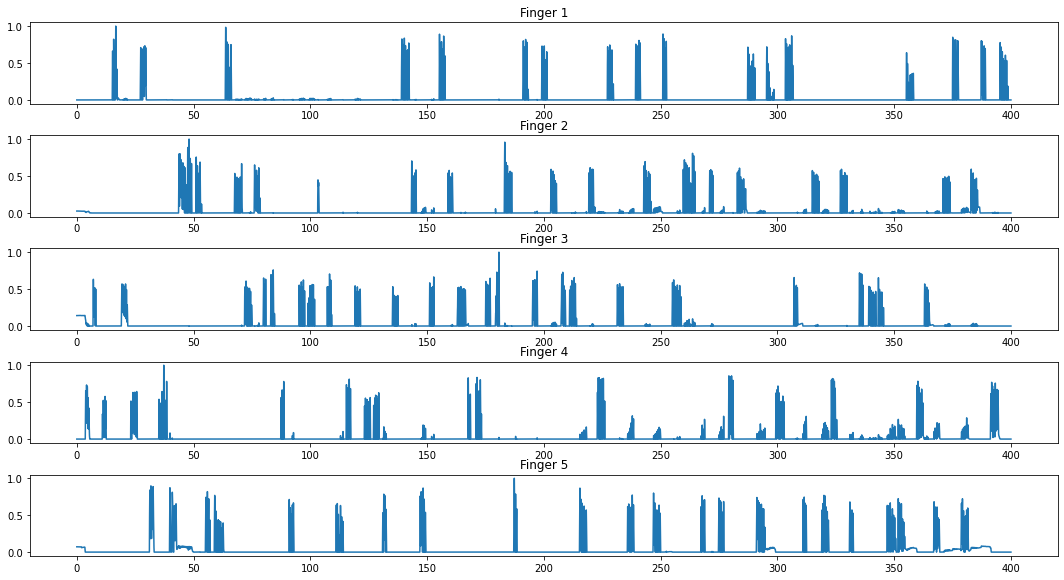

In [ ]:
## Applying the correction to all the fingers ##
## We also apply a binary activation on the finger data, so that we can create the target vector ##

fig_fingers, axes = plt.pyplot.subplots(figsize = (15,8), nrows = 5, ncols = 1)
plt.pyplot.tight_layout()
for i in range(0, 5):
    sub1['train_dg'][:, i] = process2(sub1['train_dg'][:, i])
    
    axes[i].set_title("Finger {n}".format(n = i+1)) # 0-thumb, 1-index, 2-middle ....
    axes[i].plot(np.linspace(0, 400, 400000), sub1['train_dg'][:, i])

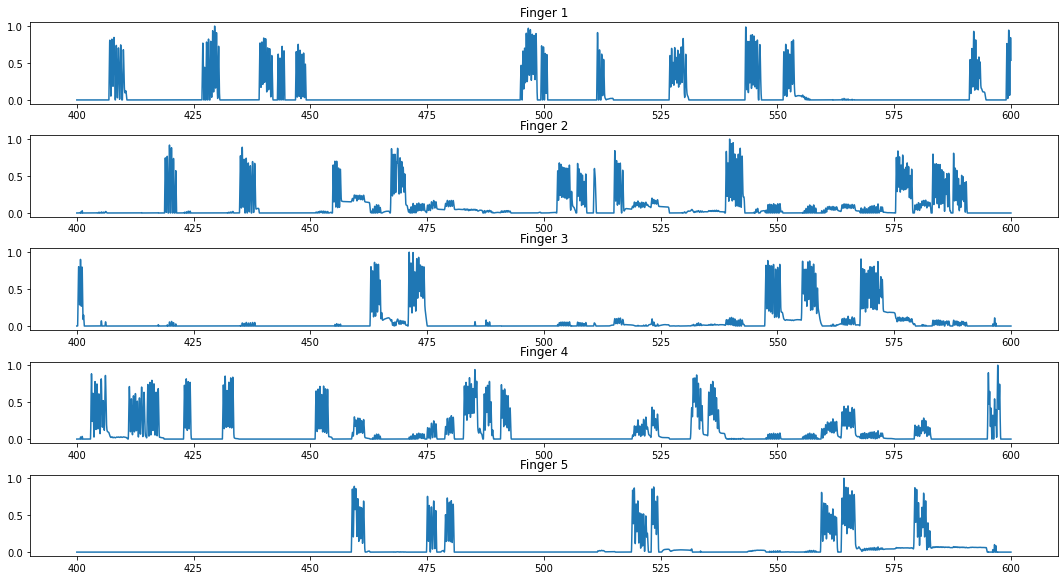

In [ ]:
i = 0
fig_fingers, axes = plt.pyplot.subplots(figsize = (15,8), nrows = 5, ncols = 1)
plt.pyplot.tight_layout()
for i in range(0, 5):
    sub1_eval['test_dg'][:, i] = process2(sub1_eval['test_dg'][:, i])
    axes[i].set_title("Finger {n}".format(n = i+1)) # 0-thumb, 1-index, 2-middle ....
    axes[i].plot(np.linspace(400, 600, 200000), sub1_eval['test_dg'][:, i])

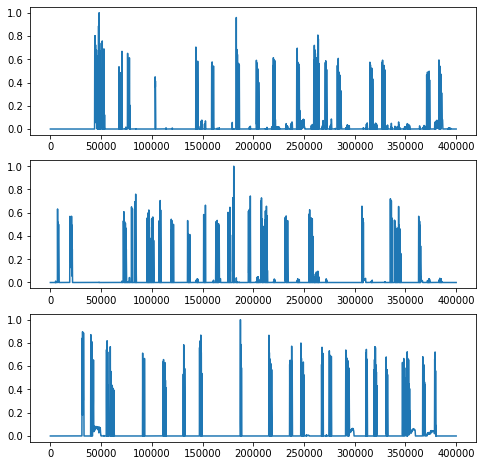

In [ ]:
# Manually cleaning the beginning of the signals
sub1['train_dg'][0:10000, 1] = 0
sub1['train_dg'][0:5000, 2] = 0
sub1['train_dg'][0:10000, 4] = 0
sub1['train_dg'][380000:400000, 4] = 0

fig_fingers, axes = plt.pyplot.subplots(figsize = (8,8), nrows = 3, ncols = 1)
axes[0].plot(sub1['train_dg'][:, 1])
axes[1].plot(sub1['train_dg'][:, 2])
axes[2].plot(sub1['train_dg'][:, 4])

In [ ]:
# def binary_activation(signal, threshold):
#     i=0
#     len = signal.shape[0]
#     binary_signal = np.zeros(len)
#     stride = 2000
    
#     for i in range(0, len-stride, stride): #timestep of 1 second
#         if np.sum(signal[i:i+stride]) > threshold:
#             binary_signal[i:i+stride] = 0.5
        
#     return binary_signal
    

In [ ]:
## Try creating a binarization algo that sets an integer value for on switch depending on the value of the peak ##
## For this try subtracting the sum from the threshold and apply a mapping of the excess to an integer(Scaling) ##
## Then instead of considering the maximum no. of points in the stride, consider the max sum (max_sum instead of max_count) ##
## This can help to solve some of the conflicts that occur due to the flexing of other fingers while flexing a finger ##

def binary_activation(signal, threshold):
    i=0
    len = signal.shape[0]
    binary_signal = np.zeros(len)
    stride = 2000
    
    for i in range(0, len-stride, stride): #timestep of 1 second
        if np.sum(signal[i:i+stride]) > threshold:
            binary_signal[i:i+stride] = ((np.sum(signal[i:i+stride]) - threshold)/np.sum(signal[i:i+stride]))
        
    return binary_signal

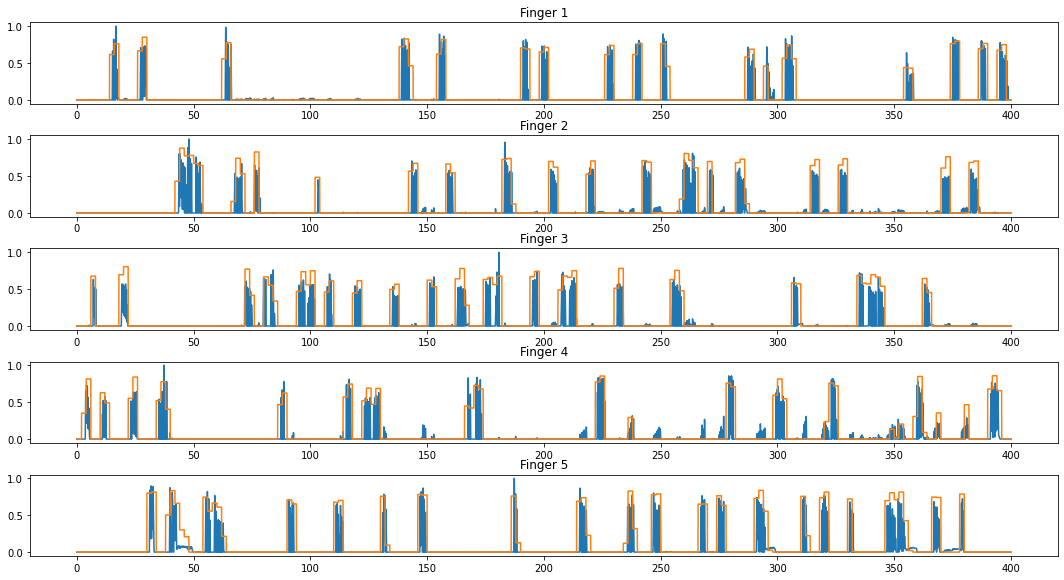

In [ ]:
j = 0
binary_signal = np.zeros(sub1['train_dg'].shape)
fig_finger, axes = plt.pyplot.subplots(figsize=(15,8), nrows=5, ncols=1)
plt.pyplot.tight_layout()
for j in range(0,5):
    binary_signal[:, j] = binary_activation(sub1['train_dg'][:, j], threshold= 100) # threshold is good at 100
    
    axes[j].set_title("Finger {n}".format(n = j+1))
    x = np.linspace(0, 400, 400000)
    axes[j].plot(x, sub1['train_dg'][:, j])
    axes[j].plot(x, binary_signal[:, j])

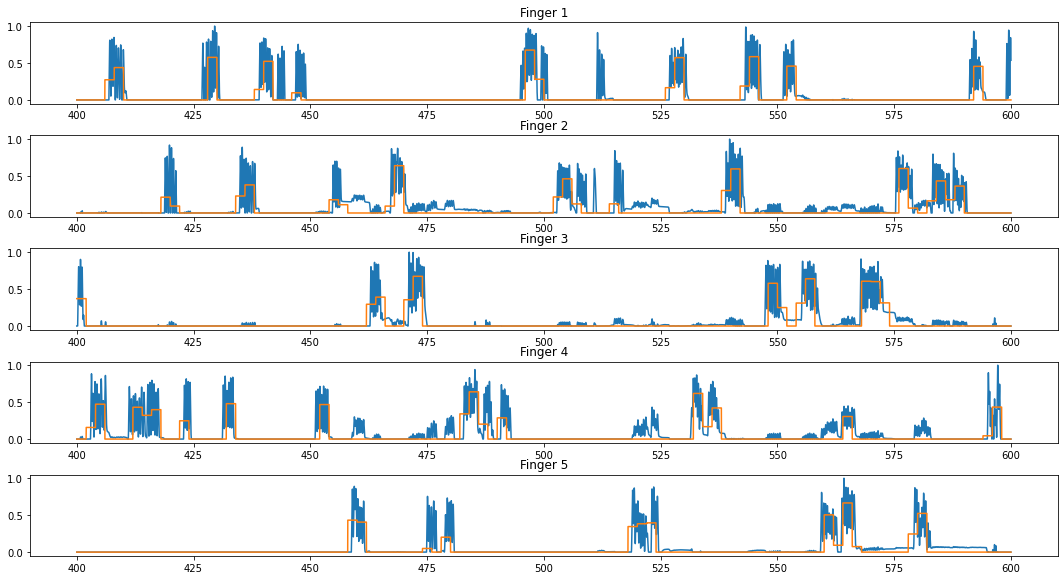

In [ ]:
j = 0
binary_test_signal = np.zeros(sub1_eval['test_dg'].shape)
fig_fingers, axes = plt.pyplot.subplots(figsize=(15, 8), nrows=5, ncols=1)
plt.pyplot.tight_layout()
for j in range(0,5):
    binary_test_signal[:, j] = binary_activation(sub1_eval['test_dg'][:, j], threshold = 400) # threshold between 300 and 400
    
    axes[j].set_title("Finger {n}".format(n = j+1))
    x = np.linspace(400, 600, 200000)
    axes[j].plot(x, sub1_eval['test_dg'][:, j])
    axes[j].plot(x, binary_test_signal[:, j])

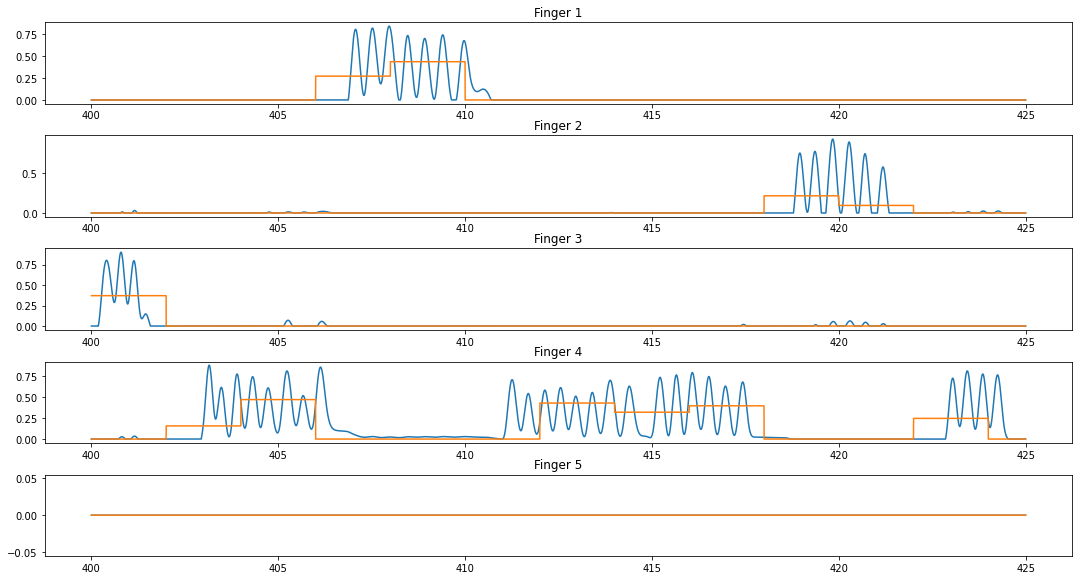

In [ ]:
j = 0
binary_test_signal = np.zeros(sub1_eval['test_dg'].shape)
fig_fingers, axes = plt.pyplot.subplots(figsize=(15, 8), nrows=5, ncols=1)
plt.pyplot.tight_layout()
for j in range(0,5):
    binary_test_signal[:, j] = binary_activation(sub1_eval['test_dg'][:, j], threshold = 400) # threshold between 300 and 400
    
    axes[j].set_title("Finger {n}".format(n = j+1))
    x = np.linspace(400, 425, 25000)
    axes[j].plot(x, sub1_eval['test_dg'][0:25000, j])
    axes[j].plot(x, binary_test_signal[0:25000, j])

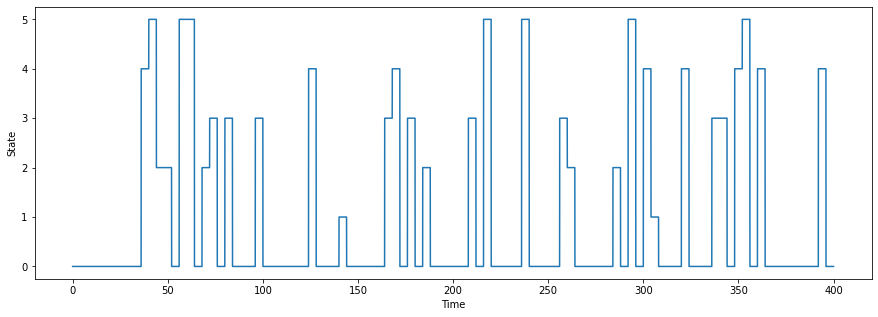

In [ ]:
# ## Generating the target training vector to which we will train the model
# target_training_vector = np.zeros(sub1['train_dg'][:, 0].shape)
# length = target_training_vector.shape[0]
# i = 0
# j = 0
# # for i in range(0, 5):
# #     target_vector[binary_signal[:, i] > 0] = i+1
    
# stride = 4000 # stride is important as it defines the batch size to send into the model
# for j in range(0, length-stride, stride):
#     max_count = np.count_nonzero(binary_signal[j:j+stride, 0] > 0)
#     value_setter = 0+1
#     for i in range(1, 5):
#         if np.count_nonzero(binary_signal[j:j+stride, i] > 0) > max_count:
#             max_count = np.count_nonzero(binary_signal[j:j+stride, i] > 0)
#             value_setter = i+1
    
#     if max_count > 2000:
#         target_training_vector[j:j+stride] = value_setter
#     else:
#         target_training_vector[j:j+stride] = 0
    
# fig = plt.pyplot.figure(figsize = (15, 5))
# plt.pyplot.xlabel('Time')
# plt.pyplot.ylabel('State')
# plt.pyplot.plot(np.linspace(0, 400, 400000), target_training_vector)


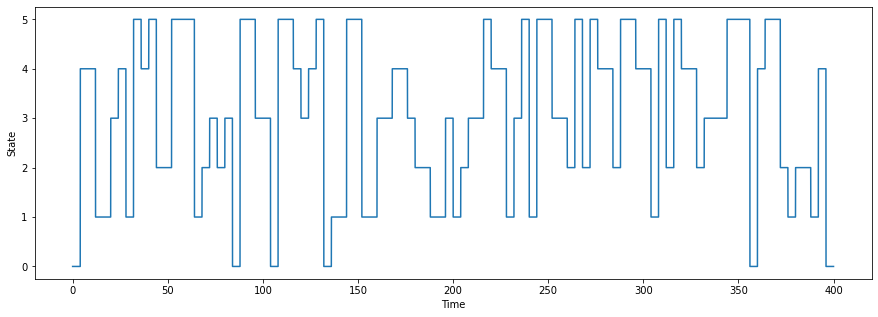

In [ ]:
## Target vector generation using max_sum for the other version of binary signal ##
target_training_vector = np.zeros(sub1['train_dg'][:, 0].shape)
length = target_training_vector.shape[0]
i = 0
j = 0
# for i in range(0, 5):
#     target_vector[binary_signal[:, i] > 0] = i+1
    
stride = 4000 # stride is important as it defines the batch size to send into the model
for j in range(0, length-stride, stride):
    max_sum = np.sum(binary_signal[j:j+stride, 0])
    value_setter = 0+1
    for i in range(1, 5):
        if np.sum(binary_signal[j:j+stride, i]) > max_sum:
            max_sum = np.sum(binary_signal[j:j+stride, i])
            value_setter = i+1
    
    if max_sum > 1000:
        target_training_vector[j:j+stride] = value_setter
    else:
        target_training_vector[j:j+stride] = 0
    
fig = plt.pyplot.figure(figsize = (15, 5))
plt.pyplot.xlabel('Time')
plt.pyplot.ylabel('State')
plt.pyplot.plot(np.linspace(0, 400, 400000), target_training_vector)

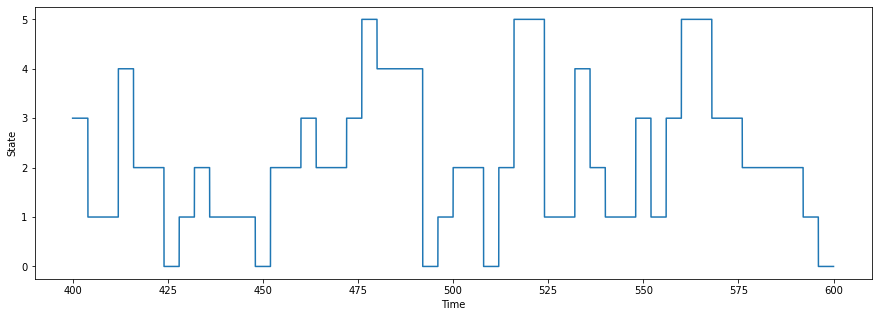

In [ ]:
# ## Generating the target test vector to which we will train the model
# target_test_vector = np.zeros(sub1_eval['test_dg'][:, 0].shape)
# length = target_test_vector.shape[0]
# i = 0
# j = 0
    
# stride = 4000 # stride is important as it defines the batch size to send into the model
# for j in range(0, length-stride, stride):
#     max_count = np.count_nonzero(binary_test_signal[j:j+stride, 0] > 0)
#     value_setter = 0+1
#     for i in range(1, 5):
#         if np.count_nonzero(binary_test_signal[j:j+stride, i] > 0) > max_count:
#             max_count = np.count_nonzero(binary_test_signal[j:j+stride, i] > 0)
#             value_setter = i+1
    
#     if max_count > 1000:
#         target_test_vector[j:j+stride] = value_setter
#     else:
#         target_test_vector[j:j+stride] = 0
    
# fig = plt.pyplot.figure(figsize = (15, 5))
# plt.pyplot.xlabel('Time')
# plt.pyplot.ylabel('State')
# plt.pyplot.plot(np.linspace(400, 600, 200000), target_test_vector)


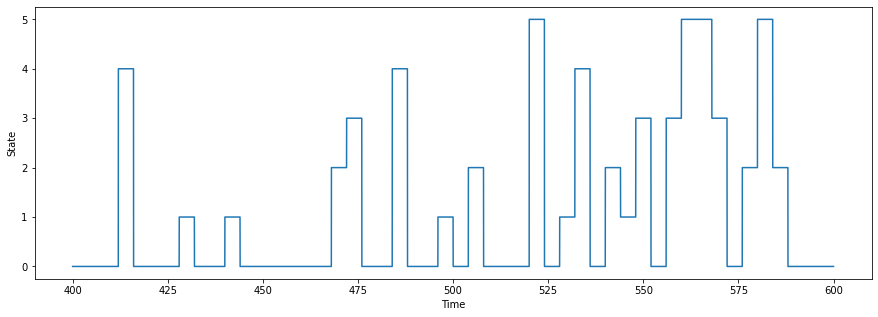

In [ ]:
## Target test vector generation using max_sum for the other version of binary signal ##
target_test_vector = np.zeros(sub1_eval['test_dg'][:, 0].shape)
length = target_test_vector.shape[0]
i = 0
j = 0
# for i in range(0, 5):
#     target_vector[binary_signal[:, i] > 0] = i+1
    
stride = 4000 # stride is important as it defines the batch size to send into the model
for j in range(0, length-stride, stride):
    max_sum = np.sum(binary_test_signal[j:j+stride, 0])
    value_setter = 0+1
    for i in range(1, 5):
        if np.sum(binary_test_signal[j:j+stride, i]) > max_sum:
            max_sum = np.sum(binary_test_signal[j:j+stride, i])
            value_setter = i+1
    
    if max_sum > 1000:
        target_test_vector[j:j+stride] = value_setter
    else:
        target_test_vector[j:j+stride] = 0
    
fig = plt.pyplot.figure(figsize = (15, 5))
plt.pyplot.xlabel('Time')
plt.pyplot.ylabel('State')
plt.pyplot.plot(np.linspace(400, 600, 200000), target_test_vector)

In [ ]:
def clean_edges(time_signal):
        freq_signal = rfft(time_signal)
        freq_x = fftfreq(time_signal.size, 1/1000)
        
        freq_signal[(np.abs(freq_x) < 0.15) | (np.abs(freq_x) > 200)] = 0
        
        time_signal = irfft(freq_signal)
        return time_signal

In [ ]:
### Filtering the ECoG signals to more specific bands ###

def signal_filter(time_signal):
    # fig = plt.pyplot.figure(figsize=(20,10))
    freq_signal = rfft(time_signal)
    freq_x = fftfreq(time_signal.size, 1/1000)

    # plt.pyplot.plot(freq_x, np.abs(freq_signal))

    # Removing any inconsistency in the signal when bandpassed between 0.15 and 200 during measurement
    freq_signal[(np.abs(freq_x) < 0.15) | (np.abs(freq_x) > 200)] = 0
    
    # Dividing the ECoG channel signal into 3 specific bands (Sanchez et. al)
    
    # sub_band = freq_signal[(np.abs(freq_x) >= 1) & (np.abs(freq_x) < 60)]
    sub_band = freq_signal
    sub_band[(np.abs(freq_x) < 1) | (np.abs(freq_x) > 60)] = 0
    
    # gamma_band = freq_signal[(np.abs(freq_x) >= 60) & (np.abs(freq_x) < 100)]
    gamma_band = freq_signal
    gamma_band[(np.abs(freq_x) <= 60) | (np.abs(freq_x) > 110)] = 0
    
    # fast_gamma_band = freq_signal[(np.abs(freq_x) >= 100) & (np.abs(freq_x) <= 200)]
    fast_gamma_band = freq_signal
    fast_gamma_band[(np.abs(freq_x) <= 110) | (np.abs(freq_x) > 200)] = 0

    sub_band_time = irfft(sub_band)
    gamma_band_time = irfft(gamma_band)
    fast_gamma_band_time = irfft(fast_gamma_band)

    # One thing you will notice is that the 3 time series bands when appended together will have considerably less data...
    # ... than the original signal while retaining all its information
    
    # cleaned_signal = irfft(freq_signal)
    return (sub_band_time, gamma_band_time, fast_gamma_band_time)

In [ ]:
i = 0
for i in range(0, sub1['train_data'].shape[1]):
    sub1['train_data'][:, i] = clean_edges(sub1['train_data'][:, i])
    sub1['test_data'][:, i] = clean_edges(sub1['test_data'][:, i])

In [ ]:
# Using one of the ECoG channels for calssification #
# Preparing the output vector for classification #

sub1_training_data = []
sub1_training_labels = []
sub1_test_data = []
sub1_test_labels = []
row = []
i = 0
stride = int(stride/1000) # From the target vector generation algorithm

for i in range(0, 400, stride):
  train_row = [[a] for a in sub1['train_data'][i*1000:i*1000+stride*1000, 0]]
  sub1_training_data.append(train_row)

  label_row = [0, 0, 0, 0, 0, 0]
  label_row[int(target_training_vector[i*1000+500])] = 1
  sub1_training_labels.append(label_row)

i=0
for i in range(0, 200, stride):
  test_row = [[a] for a in sub1['test_data'][i*1000:i*1000+stride*1000]]
  sub1_test_data.append(test_row)

  label_row = [0, 0, 0, 0, 0, 0]
  label_row[int(target_test_vector[i*1000+500])] = 1
  sub1_test_labels.append(label_row)

sub1_training_data = np.array(sub1_training_data)
sub1_training_labels = np.array(sub1_training_labels)
sub1_test_data = np.array(sub1_test_data)
sub1_test_labels = np.array(sub1_test_labels)

print(sub1_training_data.shape)
print(sub1_training_labels.shape)

(100, 4000, 1)
(100, 6)


In [ ]:
model1 = keras.models.Sequential()
model1.add(keras.layers.InputLayer((1000, 1)))
model1.add(keras.layers.LSTM(64))
model1.add(keras.layers.Dense(8, 'relu'))
model1.add(keras.layers.Dense(6, 'softmax'))

model1.summary()

cp1 = keras.callbacks.ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=keras.losses.MeanSquaredError(), optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError(), 'accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 6)                 54        
                                                                 
Total params: 17,470
Trainable params: 17,470
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.fit(sub1_training_data, sub1_training_labels, validation_split=0.25, epochs=10, callbacks=[cp1])

Epoch 1/10
10/10 [==============================] - 4s 439ms/step - loss: 0.1299 - root_mean_squared_error: 0.3604 - accuracy: 0.3233 - val_loss: 0.1416 - val_root_mean_squared_error: 0.3763 - val_accuracy: 0.1800
Epoch 2/10
10/10 [==============================] - 4s 448ms/step - loss: 0.1295 - root_mean_squared_error: 0.3599 - accuracy: 0.3233 - val_loss: 0.1415 - val_root_mean_squared_error: 0.3762 - val_accuracy: 0.1800
Epoch 3/10
10/10 [==============================] - 4s 443ms/step - loss: 0.1290 - root_mean_squared_error: 0.3591 - accuracy: 0.3367 - val_loss: 0.1415 - val_root_mean_squared_error: 0.3762 - val_accuracy: 0.1800
Epoch 4/10
10/10 [==============================] - 7s 724ms/step - loss: 0.1286 - root_mean_squared_error: 0.3587 - accuracy: 0.3433 - val_loss: 0.1396 - val_root_mean_squared_error: 0.3736 - val_accuracy: 0.1800
Epoch 5/10
10/10 [==============================] - 4s 434ms/step - loss: 0.1288 - root_mean_squared_error: 0.3589 - accuracy: 0.3400 - val_loss

In [ ]:
print(sub1_training_data.shape, sub1_training_labels.shape)

(400, 1000, 1) (400, 6)


In [ ]:
model2 = keras.models.Sequential()
model2.add(keras.layers.InputLayer((1000, 1)))
model2.add(keras.layers.Conv1D(64, kernel_size=17))
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(8, 'relu'))
model2.add(keras.layers.Dense(6, 'softmax'))

model2.summary()

cp2 = keras.callbacks.ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=keras.losses.MeanSquaredError(), optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError(), 'accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 984, 64)           1152      
                                                                 
 flatten_1 (Flatten)         (None, 62976)             0         
                                                                 
 dense_4 (Dense)             (None, 8)                 503816    
                                                                 
 dense_5 (Dense)             (None, 6)                 54        
                                                                 
Total params: 505,022
Trainable params: 505,022
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.fit(sub1_training_data, sub1_training_labels, validation_split=0.25, epochs=10, callbacks=[cp2])

Epoch 1/10
 9/10 [==========================>...] - ETA: 0s - loss: 0.2711 - root_mean_squared_error: 0.5207 - accuracy: 0.1840INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


10/10 [==============================] - 2s 115ms/step - loss: 0.2725 - root_mean_squared_error: 0.5220 - accuracy: 0.1800 - val_loss: 0.2633 - val_root_mean_squared_error: 0.5132 - val_accuracy: 0.2100
Epoch 2/10
10/10 [==============================] - 0s 28ms/step - loss: 0.2733 - root_mean_squared_error: 0.5228 - accuracy: 0.1800 - val_loss: 0.2700 - val_root_mean_squared_error: 0.5196 - val_accuracy: 0.1900
Epoch 3/10
10/10 [==============================] - 0s 28ms/step - loss: 0.2733 - root_mean_squared_error: 0.5228 - accuracy: 0.1800 - val_loss: 0.2700 - val_root_mean_squared_error: 0.5196 - val_accuracy: 0.1900
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.2756 - root_mean_squared_error: 0.5249 - accuracy: 0.1733INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


10/10 [==============================] - 1s 98ms/step - loss: 0.2756 - root_mean_squared_error: 0.5249 - accuracy: 0.1733 - val_loss: 0.2533 - val_root_mean_squared_error: 0.5033 - val_accuracy: 0.2400
Epoch 5/10
10/10 [==============================] - 0s 27ms/step - loss: 0.2733 - root_mean_squared_error: 0.5228 - accuracy: 0.1800 - val_loss: 0.2600 - val_root_mean_squared_error: 0.5099 - val_accuracy: 0.2200
Epoch 6/10
10/10 [==============================] - 0s 28ms/step - loss: 0.2744 - root_mean_squared_error: 0.5239 - accuracy: 0.1767 - val_loss: 0.2600 - val_root_mean_squared_error: 0.5099 - val_accuracy: 0.2200
Epoch 7/10
10/10 [==============================] - 0s 27ms/step - loss: 0.2733 - root_mean_squared_error: 0.5228 - accuracy: 0.1800 - val_loss: 0.2600 - val_root_mean_squared_error: 0.5099 - val_accuracy: 0.2200
Epoch 8/10
10/10 [==============================] - 0s 27ms/step - loss: 0.2744 - root_mean_squared_error: 0.5239 - accuracy: 0.1767 - val_loss: 0.2567 - val_r

In [ ]:
# Working with all the channels #
sub1_training_data = []
sub1_test_data = []

i = 0
for i in range(0, 400, stride):
  train_row = [r for r in sub1['train_data'][i*1000:i*1000+stride*1000]]
  sub1_training_data.append(train_row)

i = 0
for i in range(0, 200, stride):
  test_row = [r for r in sub1['test_data'][i*1000:i*1000+stride*1000]]
  sub1_test_data.append(test_row)

sub1_training_data = np.array(sub1_training_data)
sub1_test_data = np.array(sub1_test_data)
print(sub1_training_data.shape)
print(sub1_test_data.shape)


(100, 4000, 61)
(50, 4000, 61)


In [ ]:
model3 = keras.models.Sequential()
model3.add(keras.layers.InputLayer((stride*1000, 61)))
model3.add(keras.layers.LSTM(64))
model3.add(keras.layers.Dense(8, 'relu'))
model3.add(keras.layers.Dense(6, 'softmax'))

model3.summary()

cp3 = keras.callbacks.ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=keras.losses.MeanSquaredError(), optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError(), 'accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                32256     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 6)                 54        
                                                                 
Total params: 32,830
Trainable params: 32,830
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model3.fit(sub1_training_data, sub1_training_labels, validation_split=0.25, epochs=10, callbacks=[cp3])

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.1424 - root_mean_squared_error: 0.3773 - accuracy: 0.1933

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


10/10 [==============================] - 12s 1s/step - loss: 0.1424 - root_mean_squared_error: 0.3773 - accuracy: 0.1933 - val_loss: 0.1406 - val_root_mean_squared_error: 0.3750 - val_accuracy: 0.2000
Epoch 2/10
10/10 [==============================] - 5s 519ms/step - loss: 0.1392 - root_mean_squared_error: 0.3730 - accuracy: 0.2467 - val_loss: 0.1413 - val_root_mean_squared_error: 0.3759 - val_accuracy: 0.2000
Epoch 3/10
10/10 [==============================] - 5s 528ms/step - loss: 0.1374 - root_mean_squared_error: 0.3707 - accuracy: 0.2367 - val_loss: 0.1413 - val_root_mean_squared_error: 0.3760 - val_accuracy: 0.1700
Epoch 4/10
10/10 [==============================] - 5s 524ms/step - loss: 0.1354 - root_mean_squared_error: 0.3680 - accuracy: 0.2700 - val_loss: 0.1418 - val_root_mean_squared_error: 0.3766 - val_accuracy: 0.1600
Epoch 5/10
10/10 [==============================] - 5s 514ms/step - loss: 0.1342 - root_mean_squared_error: 0.3663 - accuracy: 0.2667 - val_loss: 0.1408 - va

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


10/10 [==============================] - 10s 1s/step - loss: 0.1326 - root_mean_squared_error: 0.3642 - accuracy: 0.2933 - val_loss: 0.1399 - val_root_mean_squared_error: 0.3741 - val_accuracy: 0.2400
Epoch 7/10
10/10 [==============================] - ETA: 0s - loss: 0.1312 - root_mean_squared_error: 0.3622 - accuracy: 0.3200

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


10/10 [==============================] - 10s 1s/step - loss: 0.1312 - root_mean_squared_error: 0.3622 - accuracy: 0.3200 - val_loss: 0.1393 - val_root_mean_squared_error: 0.3732 - val_accuracy: 0.2000
Epoch 8/10
10/10 [==============================] - 5s 508ms/step - loss: 0.1306 - root_mean_squared_error: 0.3614 - accuracy: 0.3567 - val_loss: 0.1394 - val_root_mean_squared_error: 0.3734 - val_accuracy: 0.2200
Epoch 9/10
10/10 [==============================] - 5s 513ms/step - loss: 0.1295 - root_mean_squared_error: 0.3599 - accuracy: 0.3500 - val_loss: 0.1399 - val_root_mean_squared_error: 0.3740 - val_accuracy: 0.2200
Epoch 10/10
10/10 [==============================] - 5s 550ms/step - loss: 0.1288 - root_mean_squared_error: 0.3589 - accuracy: 0.3633 - val_loss: 0.1398 - val_root_mean_squared_error: 0.3739 - val_accuracy: 0.2100


In [ ]:
model4 = keras.models.Sequential()
model4.add(keras.layers.InputLayer((stride*1000, 61)))
model4.add(keras.layers.Conv1D(8, kernel_size=17))
model4.add(keras.layers.Activation('relu'))
model4.add(keras.layers.Flatten())
model4.add(keras.layers.Dense(8, 'relu'))
model4.add(keras.layers.Dense(6, 'softmax'))
model4.summary()

cp4 = keras.callbacks.ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=keras.losses.MeanSquaredError(), optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError(), 'accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 984, 8)            8304      
                                                                 
 activation_1 (Activation)   (None, 984, 8)            0         
                                                                 
 flatten_3 (Flatten)         (None, 7872)              0         
                                                                 
 dense_10 (Dense)            (None, 8)                 62984     
                                                                 
 dense_11 (Dense)            (None, 6)                 54        
                                                                 
Total params: 71,342
Trainable params: 71,342
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model4.fit(sub1_training_data, sub1_training_labels, validation_split = 0.25, epochs=10, callbacks=[cp4])

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.2944 - root_mean_squared_error: 0.5426 - accuracy: 0.1167INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


10/10 [==============================] - 3s 257ms/step - loss: 0.2944 - root_mean_squared_error: 0.5426 - accuracy: 0.1167 - val_loss: 0.3067 - val_root_mean_squared_error: 0.5538 - val_accuracy: 0.0800
Epoch 2/10
10/10 [==============================] - 2s 166ms/step - loss: 0.3178 - root_mean_squared_error: 0.5637 - accuracy: 0.0467 - val_loss: 0.3200 - val_root_mean_squared_error: 0.5657 - val_accuracy: 0.0400
Epoch 3/10
10/10 [==============================] - 2s 167ms/step - loss: 0.3222 - root_mean_squared_error: 0.5676 - accuracy: 0.0333 - val_loss: 0.3233 - val_root_mean_squared_error: 0.5686 - val_accuracy: 0.0300
Epoch 4/10
10/10 [==============================] - 2s 164ms/step - loss: 0.3211 - root_mean_squared_error: 0.5667 - accuracy: 0.0367 - val_loss: 0.3233 - val_root_mean_squared_error: 0.5686 - val_accuracy: 0.0300
Epoch 5/10
10/10 [==============================] - 2s 165ms/step - loss: 0.3222 - root_mean_squared_error: 0.5676 - accuracy: 0.0333 - val_loss: 0.3233 - 

In [ ]:
model5 = keras.models.Sequential()
model5.add(keras.layers.InputLayer((stride*1000, 61)))
model5.add(keras.layers.LSTM(32, return_sequences=True))
model5.add(keras.layers.LSTM(64))
model5.add(keras.layers.Dense(8, 'relu'))
model5.add(keras.layers.Dense(6, 'softmax'))

model5.summary()

cp5 = keras.callbacks.ModelCheckpoint('model5/', save_best_only=True)
model5.compile(loss=keras.losses.MeanSquaredError(), optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError(), 'accuracy'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1000, 32)          12032     
                                                                 
 lstm_3 (LSTM)               (None, 64)                24832     
                                                                 
 dense_12 (Dense)            (None, 8)                 520       
                                                                 
 dense_13 (Dense)            (None, 6)                 54        
                                                                 
Total params: 37,438
Trainable params: 37,438
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model5.fit(sub1_training_data, sub1_training_labels, validation_split=0.25, epochs=10, callbacks=[cp5])

In [ ]:
model6 = keras.models.Sequential()
model6.add(keras.layers.InputLayer((1000, 61)))
model6.add(keras.layers.Conv1D(2, kernel_size=17, padding='same'))
model6.add(keras.layers.Conv1D(4, kernel_size=17, padding='same'))
model6.add(keras.layers.Conv1D(8, kernel_size=17, padding='same'))
model6.add(keras.layers.Activation('relu'))
model6.add(keras.layers.LSTM(32, return_sequences=True))
model6.add(keras.layers.LSTM(64))
model6.add(keras.layers.Dense(8, 'relu'))
model6.add(keras.layers.Dense(6, 'softmax'))

model6.summary()

cp6 = keras.callbacks.ModelCheckpoint('model6/', save_best_only=True)
model6.compile(loss=keras.losses.MeanSquaredError(), optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError(), 'accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 1000, 2)           2076      
                                                                 
 conv1d_7 (Conv1D)           (None, 1000, 4)           140       
                                                                 
 conv1d_8 (Conv1D)           (None, 1000, 8)           552       
                                                                 
 activation_2 (Activation)   (None, 1000, 8)           0         
                                                                 
 lstm_4 (LSTM)               (None, 1000, 32)          5248      
                                                                 
 lstm_5 (LSTM)               (None, 64)                24832     
                                                                 
 dense_4 (Dense)             (None, 8)                

In [ ]:
model6.fit(sub1_training_data, sub1_training_labels, validation_split=0.25, epochs=10, callbacks=[cp6])

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.1392 - root_mean_squared_error: 0.3731 - accuracy: 0.1700

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


10/10 [==============================] - 29s 2s/step - loss: 0.1392 - root_mean_squared_error: 0.3731 - accuracy: 0.1700 - val_loss: 0.1382 - val_root_mean_squared_error: 0.3718 - val_accuracy: 0.1700
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.1380 - root_mean_squared_error: 0.3715 - accuracy: 0.2167

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


10/10 [==============================] - 23s 2s/step - loss: 0.1380 - root_mean_squared_error: 0.3715 - accuracy: 0.2167 - val_loss: 0.1376 - val_root_mean_squared_error: 0.3709 - val_accuracy: 0.1700
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.1378 - root_mean_squared_error: 0.3712 - accuracy: 0.2233

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


10/10 [==============================] - 21s 2s/step - loss: 0.1378 - root_mean_squared_error: 0.3712 - accuracy: 0.2233 - val_loss: 0.1373 - val_root_mean_squared_error: 0.3705 - val_accuracy: 0.1500
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.1377 - root_mean_squared_error: 0.3711 - accuracy: 0.2067

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


10/10 [==============================] - 23s 2s/step - loss: 0.1377 - root_mean_squared_error: 0.3711 - accuracy: 0.2067 - val_loss: 0.1372 - val_root_mean_squared_error: 0.3704 - val_accuracy: 0.1700
Epoch 5/10
10/10 [==============================] - ETA: 0s - loss: 0.1375 - root_mean_squared_error: 0.3708 - accuracy: 0.2067

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


10/10 [==============================] - 22s 2s/step - loss: 0.1375 - root_mean_squared_error: 0.3708 - accuracy: 0.2067 - val_loss: 0.1370 - val_root_mean_squared_error: 0.3702 - val_accuracy: 0.1700
Epoch 6/10
10/10 [==============================] - ETA: 0s - loss: 0.1372 - root_mean_squared_error: 0.3704 - accuracy: 0.2133

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


10/10 [==============================] - 22s 2s/step - loss: 0.1372 - root_mean_squared_error: 0.3704 - accuracy: 0.2133 - val_loss: 0.1365 - val_root_mean_squared_error: 0.3694 - val_accuracy: 0.1700
Epoch 7/10
10/10 [==============================] - ETA: 0s - loss: 0.1370 - root_mean_squared_error: 0.3701 - accuracy: 0.2100

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


10/10 [==============================] - 23s 2s/step - loss: 0.1370 - root_mean_squared_error: 0.3701 - accuracy: 0.2100 - val_loss: 0.1363 - val_root_mean_squared_error: 0.3692 - val_accuracy: 0.1700
Epoch 8/10
10/10 [==============================] - 14s 1s/step - loss: 0.1372 - root_mean_squared_error: 0.3704 - accuracy: 0.2100 - val_loss: 0.1367 - val_root_mean_squared_error: 0.3697 - val_accuracy: 0.1800
Epoch 9/10
10/10 [==============================] - 16s 2s/step - loss: 0.1368 - root_mean_squared_error: 0.3699 - accuracy: 0.2100 - val_loss: 0.1368 - val_root_mean_squared_error: 0.3699 - val_accuracy: 0.1600
Epoch 10/10
10/10 [==============================] - 14s 1s/step - loss: 0.1369 - root_mean_squared_error: 0.3701 - accuracy: 0.2100 - val_loss: 0.1368 - val_root_mean_squared_error: 0.3699 - val_accuracy: 0.1700


In [ ]:
sub1_training_data = []

sub_band = np.zeros(sub1['train_data'].shape)
gamma_band = np.zeros(sub1['train_data'].shape)
fast_gamma_band = np.zeros(sub1['train_data'].shape)

i = 0
for i in range(0, 61):
  (sub_band[:, i], gamma_band[:, i], fast_gamma_band[:, i]) = signal_filter(sub1['train_data'][:, i])

i = 0
for i in range(0, 400, stride):
  s_row = [r1 for r1 in sub_band[i*1000:i*1000+stride*1000]]
  g_row = [r2 for r2 in gamma_band[i*1000:i*1000+stride*1000]]
  fg_row = [r3 for r3 in fast_gamma_band[i*1000:i*1000+stride*1000]]
  sub1_training_data.append(s_row + g_row + fg_row)
  

sub1_training_data = np.array(sub1_training_data)

print(sub1_training_data.shape)

(100, 12000, 61)


In [ ]:
# Create training data from the Gamma Band (60 Hz< and >110 Hz) #

gamma_band_training_data = []

i = 0
for i in range(0, 400, stride):
  g_row = [r2 for r2 in gamma_band[i*1000:i*1000+stride*1000]]
  gamma_band_training_data.append(g_row)

gamma_band_training_data = np.array(gamma_band_training_data)
print(gamma_band_training_data.shape)

(400, 1000, 61)


In [ ]:
model7 = keras.models.Sequential()
model7.add(keras.layers.InputLayer((stride*1000, 61)))
model7.add(keras.layers.LSTM(64))
model7.add(keras.layers.Dense(8, 'relu'))
model7.add(keras.layers.Dense(6, 'softmax'))

model7.summary()

cp7 =keras.callbacks.ModelCheckpoint('model7/', save_best_only=True)
model7.compile(loss=keras.losses.MeanSquaredError(), optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError(), 'accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                32256     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 6)                 54        
                                                                 
Total params: 32,830
Trainable params: 32,830
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model7.fit(gamma_band_training_data, sub1_training_labels, validation_split=0.25, epochs=10, callbacks=[cp7])

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.1388 - root_mean_squared_error: 0.3726 - accuracy: 0.2167

INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


10/10 [==============================] - 14s 1s/step - loss: 0.1388 - root_mean_squared_error: 0.3726 - accuracy: 0.2167 - val_loss: 0.1388 - val_root_mean_squared_error: 0.3726 - val_accuracy: 0.1800
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.1387 - root_mean_squared_error: 0.3725 - accuracy: 0.2467

INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


10/10 [==============================] - 10s 1s/step - loss: 0.1387 - root_mean_squared_error: 0.3725 - accuracy: 0.2467 - val_loss: 0.1387 - val_root_mean_squared_error: 0.3725 - val_accuracy: 0.1800
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.1386 - root_mean_squared_error: 0.3723 - accuracy: 0.2467

INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


10/10 [==============================] - 11s 1s/step - loss: 0.1386 - root_mean_squared_error: 0.3723 - accuracy: 0.2467 - val_loss: 0.1387 - val_root_mean_squared_error: 0.3724 - val_accuracy: 0.1800
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.1385 - root_mean_squared_error: 0.3722 - accuracy: 0.2467

INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


10/10 [==============================] - 10s 1s/step - loss: 0.1385 - root_mean_squared_error: 0.3722 - accuracy: 0.2467 - val_loss: 0.1386 - val_root_mean_squared_error: 0.3723 - val_accuracy: 0.1800
Epoch 5/10
10/10 [==============================] - ETA: 0s - loss: 0.1384 - root_mean_squared_error: 0.3720 - accuracy: 0.2467

INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


10/10 [==============================] - 11s 1s/step - loss: 0.1384 - root_mean_squared_error: 0.3720 - accuracy: 0.2467 - val_loss: 0.1385 - val_root_mean_squared_error: 0.3722 - val_accuracy: 0.1800
Epoch 6/10
10/10 [==============================] - ETA: 0s - loss: 0.1383 - root_mean_squared_error: 0.3719 - accuracy: 0.2467

INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


10/10 [==============================] - 12s 1s/step - loss: 0.1383 - root_mean_squared_error: 0.3719 - accuracy: 0.2467 - val_loss: 0.1385 - val_root_mean_squared_error: 0.3721 - val_accuracy: 0.1800
Epoch 7/10
10/10 [==============================] - ETA: 0s - loss: 0.1382 - root_mean_squared_error: 0.3718 - accuracy: 0.2467

INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


10/10 [==============================] - 11s 1s/step - loss: 0.1382 - root_mean_squared_error: 0.3718 - accuracy: 0.2467 - val_loss: 0.1384 - val_root_mean_squared_error: 0.3720 - val_accuracy: 0.1800
Epoch 8/10
10/10 [==============================] - ETA: 0s - loss: 0.1381 - root_mean_squared_error: 0.3716 - accuracy: 0.2467

INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


10/10 [==============================] - 11s 1s/step - loss: 0.1381 - root_mean_squared_error: 0.3716 - accuracy: 0.2467 - val_loss: 0.1383 - val_root_mean_squared_error: 0.3719 - val_accuracy: 0.1800
Epoch 9/10
10/10 [==============================] - ETA: 0s - loss: 0.1380 - root_mean_squared_error: 0.3715 - accuracy: 0.2467

INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


10/10 [==============================] - 11s 1s/step - loss: 0.1380 - root_mean_squared_error: 0.3715 - accuracy: 0.2467 - val_loss: 0.1383 - val_root_mean_squared_error: 0.3718 - val_accuracy: 0.1800
Epoch 10/10
10/10 [==============================] - ETA: 0s - loss: 0.1379 - root_mean_squared_error: 0.3714 - accuracy: 0.2467

INFO:tensorflow:Assets written to: model7/assets


INFO:tensorflow:Assets written to: model7/assets


10/10 [==============================] - 11s 1s/step - loss: 0.1379 - root_mean_squared_error: 0.3714 - accuracy: 0.2467 - val_loss: 0.1382 - val_root_mean_squared_error: 0.3718 - val_accuracy: 0.1800


In [ ]:
model9 = keras.models.Sequential()
model9.add(keras.layers.InputLayer((stride*1000, 61)))
model9.add(keras.layers.LSTM(32, return_sequences=True))
model9.add(keras.layers.LSTM(64))
model9.add(keras.layers.Dense(8, 'relu'))
model9.add(keras.layers.Dense(6, 'softmax'))

model9.summary()

cp9 = keras.callbacks.ModelCheckpoint('model9/', save_best_only=True)
model9.compile(loss=keras.losses.MeanSquaredError(), optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError(), 'accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1000, 32)          12032     
                                                                 
 lstm_4 (LSTM)               (None, 64)                24832     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 6)                 54        
                                                                 
Total params: 37,438
Trainable params: 37,438
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model9.fit(gamma_band_training_data, sub1_training_labels, validation_split=0.25, epochs=10)

Epoch 1/10
10/10 [==============================] - 11s 1s/step - loss: 0.1371 - root_mean_squared_error: 0.3703 - accuracy: 0.1867 - val_loss: 0.1381 - val_root_mean_squared_error: 0.3716 - val_accuracy: 0.1600
Epoch 2/10
10/10 [==============================] - 11s 1s/step - loss: 0.1367 - root_mean_squared_error: 0.3698 - accuracy: 0.2333 - val_loss: 0.1365 - val_root_mean_squared_error: 0.3694 - val_accuracy: 0.1800
Epoch 3/10
10/10 [==============================] - 11s 1s/step - loss: 0.1361 - root_mean_squared_error: 0.3689 - accuracy: 0.1767 - val_loss: 0.1362 - val_root_mean_squared_error: 0.3691 - val_accuracy: 0.1800
Epoch 4/10
10/10 [==============================] - 11s 1s/step - loss: 0.1355 - root_mean_squared_error: 0.3681 - accuracy: 0.2467 - val_loss: 0.1357 - val_root_mean_squared_error: 0.3684 - val_accuracy: 0.1800
Epoch 5/10
10/10 [==============================] - 11s 1s/step - loss: 0.1355 - root_mean_squared_error: 0.3681 - accuracy: 0.2467 - val_loss: 0.1365 -

In [ ]:
print(sub1_training_data.shape)
print(gamma_band_training_data.shape)

(400, 1000, 61)
(400, 1000, 61)


In [ ]:
model10 = keras.models.Sequential()
model10.add(keras.layers.InputLayer((stride*1000, 61)))
model10.add(keras.layers.Conv1D(1, kernel_size=1))
model10.add(keras.layers.LSTM(32, return_sequences=True))
model10.add(keras.layers.LSTM(64))
model10.add(keras.layers.Dense(8, 'relu'))
model10.add(keras.layers.Dense(6, 'softmax'))

model10.summary()

cp10 =keras.callbacks.ModelCheckpoint('model10/', save_best_only=True)
model10.compile(loss=keras.losses.MeanSquaredError(), optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError(), 'accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 1000, 1)           62        
                                                                 
 lstm_6 (LSTM)               (None, 1000, 32)          4352      
                                                                 
 lstm_7 (LSTM)               (None, 64)                24832     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 6)                 54        
                                                                 
Total params: 29,820
Trainable params: 29,820
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model10.fit(sub1_training_data, sub1_training_labels, validation_split=0.25, epochs=10, callbacks=[cp10])

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.1375 - root_mean_squared_error: 0.3707 - accuracy: 0.2267

INFO:tensorflow:Assets written to: model10/assets


INFO:tensorflow:Assets written to: model10/assets


10/10 [==============================] - 28s 2s/step - loss: 0.1375 - root_mean_squared_error: 0.3707 - accuracy: 0.2267 - val_loss: 0.1401 - val_root_mean_squared_error: 0.3744 - val_accuracy: 0.1800
Epoch 2/10
10/10 [==============================] - 12s 1s/step - loss: 0.1355 - root_mean_squared_error: 0.3681 - accuracy: 0.2467 - val_loss: 0.1406 - val_root_mean_squared_error: 0.3750 - val_accuracy: 0.1800
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.1357 - root_mean_squared_error: 0.3683 - accuracy: 0.2467

INFO:tensorflow:Assets written to: model10/assets


INFO:tensorflow:Assets written to: model10/assets


10/10 [==============================] - 22s 2s/step - loss: 0.1357 - root_mean_squared_error: 0.3683 - accuracy: 0.2467 - val_loss: 0.1396 - val_root_mean_squared_error: 0.3736 - val_accuracy: 0.1800
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.1351 - root_mean_squared_error: 0.3675 - accuracy: 0.2467

INFO:tensorflow:Assets written to: model10/assets


INFO:tensorflow:Assets written to: model10/assets


10/10 [==============================] - 23s 2s/step - loss: 0.1351 - root_mean_squared_error: 0.3675 - accuracy: 0.2467 - val_loss: 0.1390 - val_root_mean_squared_error: 0.3728 - val_accuracy: 0.1800
Epoch 5/10
10/10 [==============================] - 12s 1s/step - loss: 0.1350 - root_mean_squared_error: 0.3674 - accuracy: 0.2467 - val_loss: 0.1398 - val_root_mean_squared_error: 0.3740 - val_accuracy: 0.1800
Epoch 6/10
10/10 [==============================] - 12s 1s/step - loss: 0.1348 - root_mean_squared_error: 0.3671 - accuracy: 0.2433 - val_loss: 0.1392 - val_root_mean_squared_error: 0.3732 - val_accuracy: 0.1800
Epoch 7/10
10/10 [==============================] - 12s 1s/step - loss: 0.1347 - root_mean_squared_error: 0.3670 - accuracy: 0.2433 - val_loss: 0.1394 - val_root_mean_squared_error: 0.3733 - val_accuracy: 0.1800
Epoch 8/10
10/10 [==============================] - 11s 1s/step - loss: 0.1345 - root_mean_squared_error: 0.3668 - accuracy: 0.2467 - val_loss: 0.1400 - val_root_m

INFO:tensorflow:Assets written to: model10/assets


INFO:tensorflow:Assets written to: model10/assets


10/10 [==============================] - 22s 2s/step - loss: 0.1343 - root_mean_squared_error: 0.3665 - accuracy: 0.2433 - val_loss: 0.1385 - val_root_mean_squared_error: 0.3722 - val_accuracy: 0.1800


In [ ]:
model11 = keras.models.Sequential()
model11.add(keras.layers.InputLayer((stride*1000, 61)))
model11.add(keras.layers.LSTM(32, return_sequences=True))
model11.add(keras.layers.LSTM(64))
model11.add(keras.layers.Dense(8, 'relu'))
model11.add(keras.layers.Dense(6, 'softmax'))

model11.summary()

cp11 =keras.callbacks.ModelCheckpoint('model11/', save_best_only=True)
model11.compile(loss=keras.losses.MeanSquaredError(), optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError(), 'accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1000, 32)          12032     
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 6)                 54        
                                                                 
Total params: 37,438
Trainable params: 37,438
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model11.fit(sub1_training_data, sub1_training_labels, validation_split=0.25, epochs=5, callbacks=[cp11])

Epoch 1/5
10/10 [==============================] - ETA: 0s - loss: 0.1379 - root_mean_squared_error: 0.3713 - accuracy: 0.2100

INFO:tensorflow:Assets written to: model11/assets


INFO:tensorflow:Assets written to: model11/assets


10/10 [==============================] - 24s 2s/step - loss: 0.1379 - root_mean_squared_error: 0.3713 - accuracy: 0.2100 - val_loss: 0.1391 - val_root_mean_squared_error: 0.3730 - val_accuracy: 0.1600
Epoch 2/5
10/10 [==============================] - 9s 912ms/step - loss: 0.1342 - root_mean_squared_error: 0.3663 - accuracy: 0.3067 - val_loss: 0.1395 - val_root_mean_squared_error: 0.3735 - val_accuracy: 0.1700
Epoch 3/5
10/10 [==============================] - 9s 912ms/step - loss: 0.1317 - root_mean_squared_error: 0.3630 - accuracy: 0.3133 - val_loss: 0.1403 - val_root_mean_squared_error: 0.3745 - val_accuracy: 0.1700
Epoch 4/5
10/10 [==============================] - 9s 915ms/step - loss: 0.1289 - root_mean_squared_error: 0.3590 - accuracy: 0.3367 - val_loss: 0.1413 - val_root_mean_squared_error: 0.3759 - val_accuracy: 0.1600
Epoch 5/5
10/10 [==============================] - 9s 923ms/step - loss: 0.1261 - root_mean_squared_error: 0.3551 - accuracy: 0.3467 - val_loss: 0.1431 - val_ro

In [ ]:
model11.evaluate(sub1_test_data, sub1_test_labels)

7/7 [==============================] - 2s 172ms/step - loss: 0.1462 - root_mean_squared_error: 0.3823 - accuracy: 0.1350


[0.1461591124534607, 0.38230764865875244, 0.13500000536441803]

In [ ]:
predicted_signal = model11.predict()

In [ ]:
# First model to be run with a stride length of 4s (4000 data points) #

model12 = keras.models.Sequential()
model12.add(keras.layers.InputLayer((stride*1000, 61)))
model12.add(keras.layers.LSTM(32, return_sequences=True))
model12.add(keras.layers.LSTM(64))
model12.add(keras.layers.Dense(8, 'relu'))
model12.add(keras.layers.Dense(6, 'softmax'))

model12.summary()

cp12 = keras.callbacks.ModelCheckpoint('model12/', save_best_only=True)
model12.compile(loss=keras.losses.MeanSquaredError(), optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError(), 'accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4000, 32)          12032     
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 6)                 54        
                                                                 
Total params: 37,438
Trainable params: 37,438
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model12.fit(sub1_training_data, sub1_training_labels, validation_split=0.25, epochs=10, callbacks=[cp12])

Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 0.1391 - root_mean_squared_error: 0.3729 - accuracy: 0.2400

INFO:tensorflow:Assets written to: model12/assets


INFO:tensorflow:Assets written to: model12/assets


3/3 [==============================] - 31s 10s/step - loss: 0.1391 - root_mean_squared_error: 0.3729 - accuracy: 0.2400 - val_loss: 0.1414 - val_root_mean_squared_error: 0.3760 - val_accuracy: 0.0000e+00
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 0.1361 - root_mean_squared_error: 0.3689 - accuracy: 0.3200

INFO:tensorflow:Assets written to: model12/assets


INFO:tensorflow:Assets written to: model12/assets


3/3 [==============================] - 24s 10s/step - loss: 0.1361 - root_mean_squared_error: 0.3689 - accuracy: 0.3200 - val_loss: 0.1413 - val_root_mean_squared_error: 0.3760 - val_accuracy: 0.0400
Epoch 3/10
3/3 [==============================] - 14s 5s/step - loss: 0.1338 - root_mean_squared_error: 0.3658 - accuracy: 0.3200 - val_loss: 0.1415 - val_root_mean_squared_error: 0.3761 - val_accuracy: 0.0400
Epoch 4/10
3/3 [==============================] - 14s 5s/step - loss: 0.1319 - root_mean_squared_error: 0.3631 - accuracy: 0.3733 - val_loss: 0.1416 - val_root_mean_squared_error: 0.3763 - val_accuracy: 0.0400
Epoch 5/10
3/3 [==============================] - 14s 5s/step - loss: 0.1300 - root_mean_squared_error: 0.3605 - accuracy: 0.3867 - val_loss: 0.1419 - val_root_mean_squared_error: 0.3767 - val_accuracy: 0.0000e+00
Epoch 6/10
3/3 [==============================] - 14s 5s/step - loss: 0.1275 - root_mean_squared_error: 0.3571 - accuracy: 0.4000 - val_loss: 0.1427 - val_root_mean_s

In [ ]:
model12.evaluate(sub1_test_data, sub1_test_labels)

2/2 [==============================] - 3s 674ms/step - loss: 0.1435 - root_mean_squared_error: 0.3789 - accuracy: 0.1600


[0.14353279769420624, 0.37885722517967224, 0.1599999964237213]